### Estimation of Muon Decay Time

In [38]:
# Pip imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import stan

try:
    import arviz as az
except ImportError as err:
    print("Please, install arviz for easy visualization of Stan models.")

import nest_asyncio
nest_asyncio.apply()

import pandas as pd

print(stan.__version__)

3.10.0


In [55]:
# Simulate Data
def gen_data(theta, w, num_samples): #theta[0]: lambda, theta[1]: alpha, theta[2]: beta
    # Generate each distribution
    num_muons = int(w*num_samples)
    num_background = num_samples - num_muons
    obs_time_range = [1, 39999]
    # muon_distr = (obs_time_range[1] * np.random.exponential(scale=theta[0]*10**3, size=(num_muons,))).astype(np.uint64) #This needs to be normalized to obs_time_range
    muon_distr = np.random.exponential(scale=theta[0]*10**3, size=(num_muons,)).astype(np.uint64) #This needs to be normalized to obs_time_range
    muon_distr[muon_distr==0] = 1
    background_distr = np.random.uniform(low=obs_time_range[0], high=obs_time_range[1] + 1, size=(num_background,)).astype(np.uint64)
    background_distr[background_distr==0] = 1

    mixed_distr = np.concatenate([muon_distr, background_distr])
    np.random.shuffle(mixed_distr)

    return mixed_distr

39.872 0.001


Text(0.5, 0, 'Measured Decay Times ($\\mu s$)')

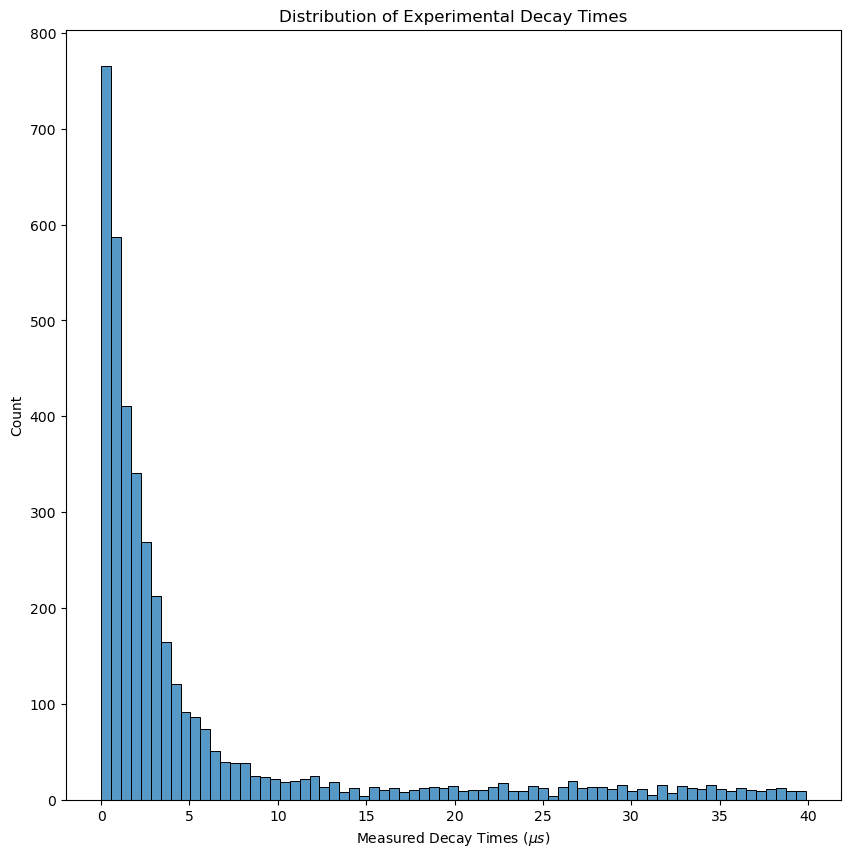

In [ ]:
synth_data = gen_data([2.2], 0.8, 4004).astype(np.float64) * 10**(-3)
print(max(synth_data), min(synth_data))

# Bin detected decays into a histogram
width = 0.5
tau_distribution_synth, bin_edges = np.histogram(synth_data, bins=np.arange(min(synth_data), max(synth_data) + width, width))

# Plot histogram of experimental data
plt.figure(figsize=(10,10))
ax = sns.histplot(synth_data)
plt.title("Distribution of Experimental Decay Times")
plt.xlabel("Measured Decay Times ($\\mu s$)")

In [41]:
stan_code = """

data {
    int<lower=1> N; // Size of the data
    vector[N] eps; // Number of events
    vector[N] y; // Vector of distributions (?)
}

parameters {
    real lambda; // Decay rate of a muon
    real beta; // Regression parameter
}

model {
    lambda ~ gamma(2, 2);
    // lambda ~ lognormal(2, 2);
    // lambda ~ poisson(0.5);
    // lambda ~ exponential(0.5);
    beta ~ normal(0, 2);

    y ~ exponential(lambda + beta * eps);
}

"""

In [43]:
# Read in data
data = pd.read_csv("Data/sifted.csv", delimiter=';')
data = data.sample(frac=1).reset_index(drop=True)
print(data)
tau_experimental = data["ObsTime"].astype(np.float64) * 10**(-3) # Separate the decay times and convert them from nanoseconds to microseconds

      ObsTime       Epoch
0       11800  1690427783
1        4620  1690358104
2         160  1690325195
3        9140  1690453501
4        1620  1690564256
...       ...         ...
4000     1440  1690402564
4001     4400  1690390079
4002      340  1690440910
4003      720  1690502956
4004     3500  1690383391

[4005 rows x 2 columns]


19.84 0.04


Text(0.5, 0, 'Measured Decay Times ($\\mu s$)')

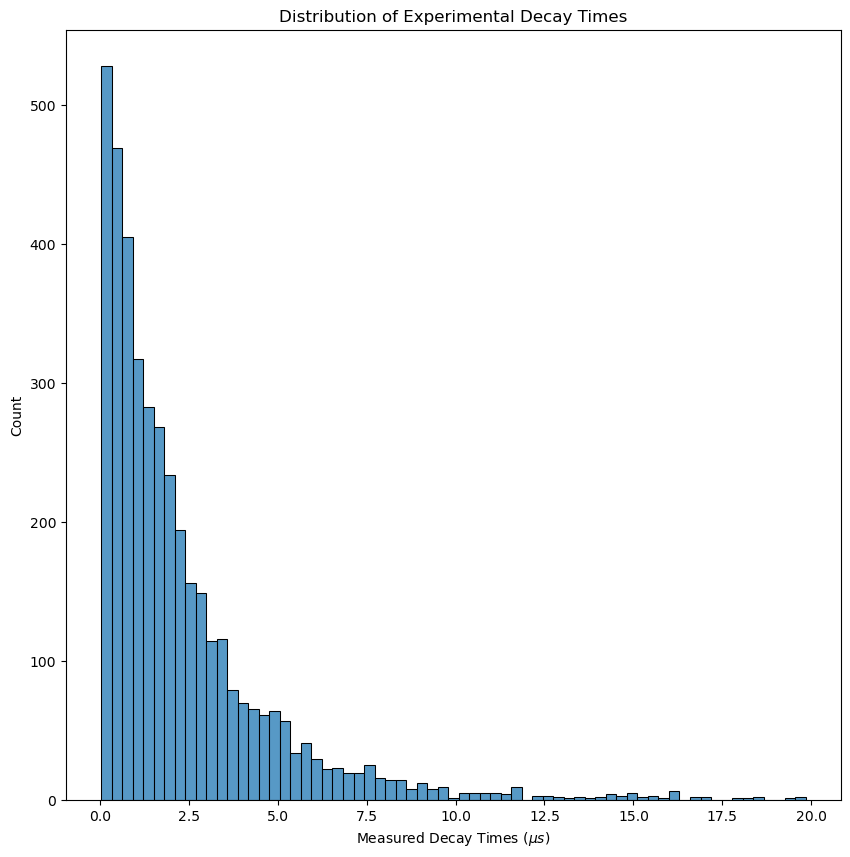

In [44]:
# Bin detected decays into a histogram
width = 0.5
tau_distribution, bin_edges = np.histogram(tau_experimental, bins=np.arange(min(tau_experimental), max(tau_experimental) + width, width))

print(max(tau_experimental), min(tau_experimental)) #(DEBUG)

# Plot histogram of experimental data
plt.figure(figsize=(10,10))
ax = sns.histplot(tau_experimental)
plt.title("Distribution of Experimental Decay Times")
plt.xlabel("Measured Decay Times ($\\mu s$)")

In [26]:
# Stan model
data_dict = {
    "N": tau_distribution.shape[0],
    "eps": tau_distribution,
    "y": 1/tau_distribution
}

model = stan.build(stan_code, data=data_dict)

Building...

In [ ]:
fit = model.sample(num_chains=4, num_samples=4000, num_warmup=1000)

Sampling:   0%
Sampling:  25% (5000/20000)
Sampling:  50% (10000/20000)
Sampling:  75% (15000/20000)
Sampling: 100% (20000/20000)
Sampling: 100% (20000/20000), done.
Messages received during sampling:
warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: exponential_lpdf: Inverse scale parameter[1] is -253.239, but must be positive finite! (in '/tmp/httpstan_fyutv7yo/model_obowzxdy.stan', line 21, column 4 to column 41)
warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: exponential_lpdf: Inverse scale parameter[1] is -393.804, but must be positive finite! (in '/tmp/httpstan_fyutv7yo/model_obowzxdy.stan', line 21, column 4 to column 41)
  Gradient evaluation took 2.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.28 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be

In [ ]:
tau_estimated = 1/fit["lambda"][0]

print(f"Mean Tau: {np.round(np.mean(tau_estimated), 3)} ± {np.round(np.std(tau_estimated))} 𝜇𝑠") #Is the mean even what we actually want? (DEBUG)
az.summary(fit, var_names=['lambda', 'beta'], filter_vars="like")

Mean Tau: 3.427 ± 5.0 𝜇𝑠


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda,0.521,0.328,0.028,1.110,0.005,0.005,4435.0,4627.0,1.0
beta,0.928,0.166,0.627,1.246,0.002,0.002,5018.0,3668.0,1.0


array([[<Axes: title={'center': 'lambda'}>,
        <Axes: title={'center': 'lambda'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

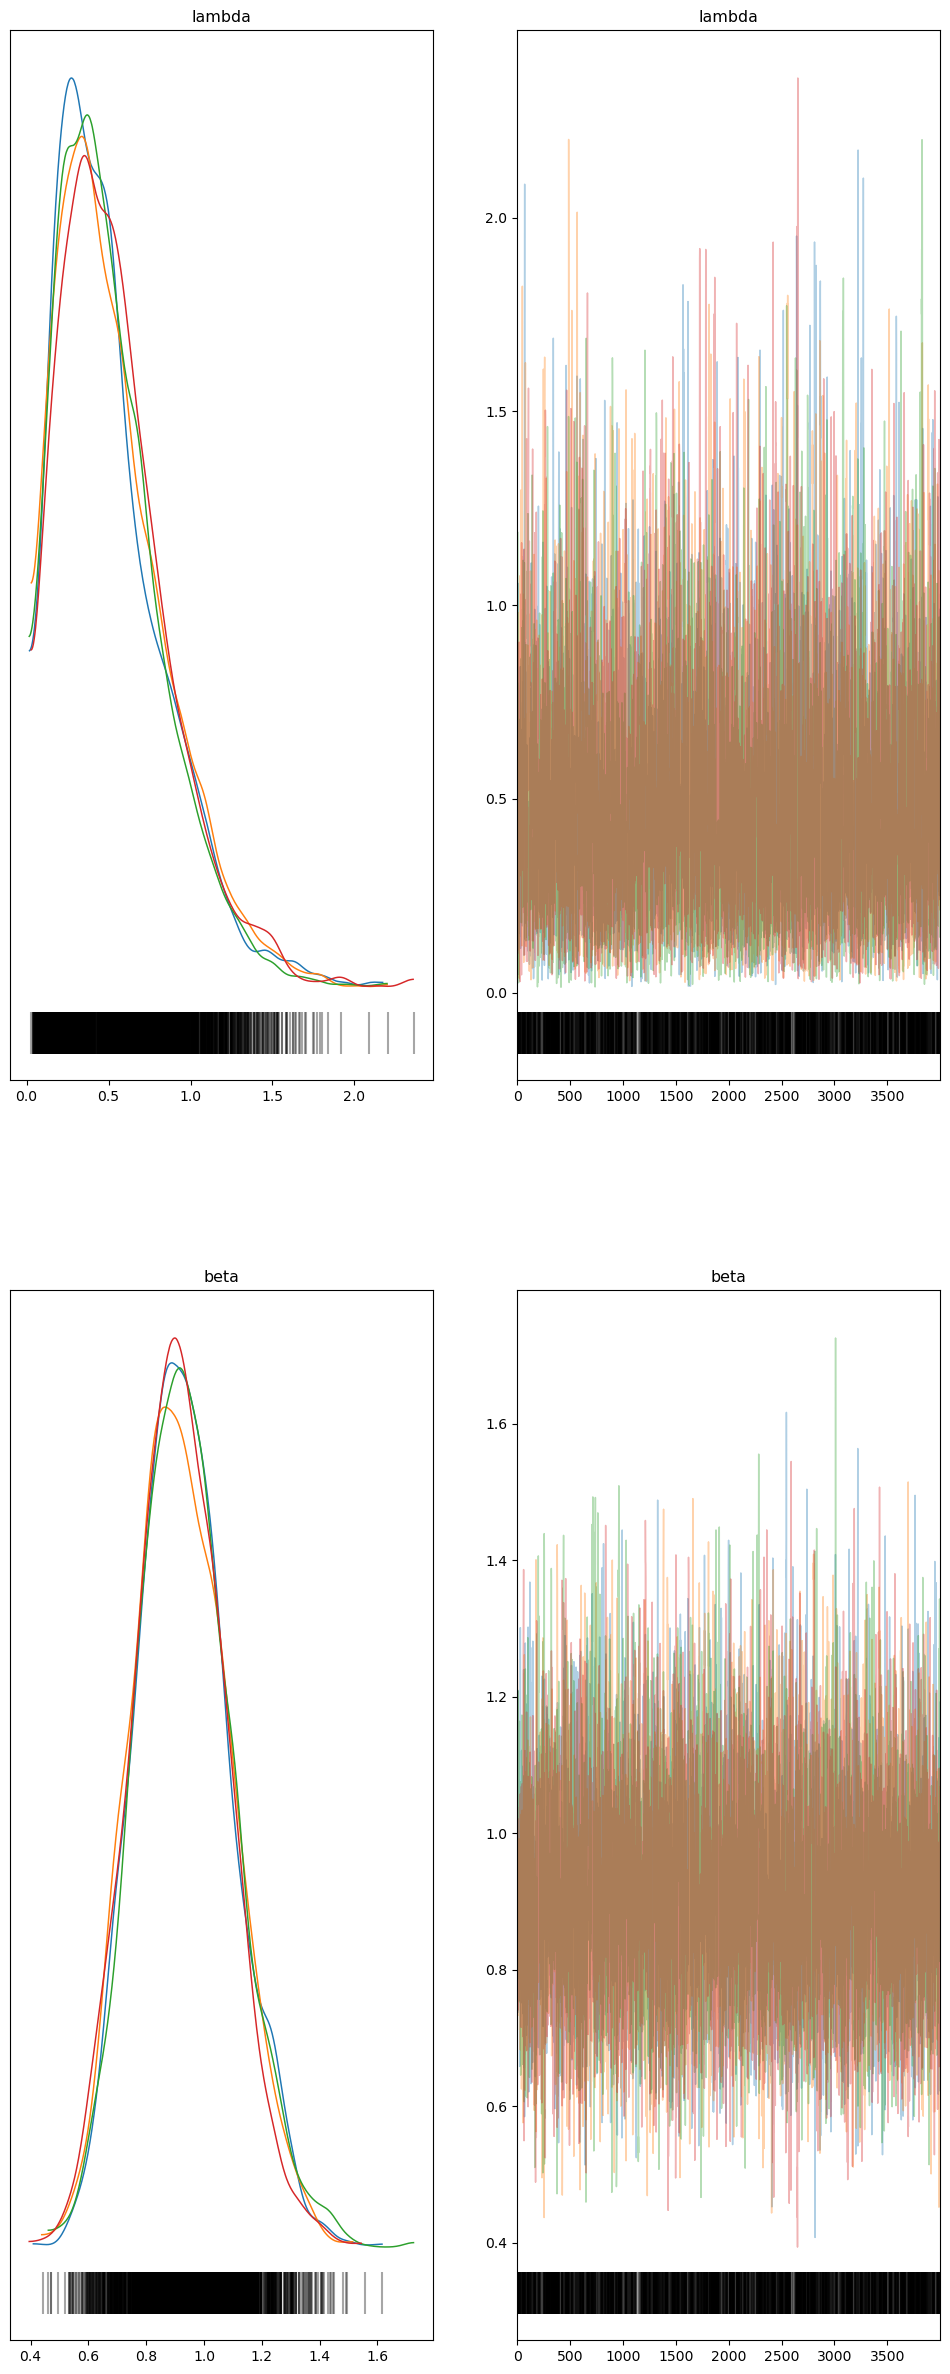

In [ ]:
columns_to_plot_trace_of = ['lambda', 'beta']

az.plot_trace(fit, var_names=columns_to_plot_trace_of, filter_vars='like', compact=False, figsize=(12, 30))

Text(0.5, 0, 'Estimated Decay Times ($\\mu s$)')

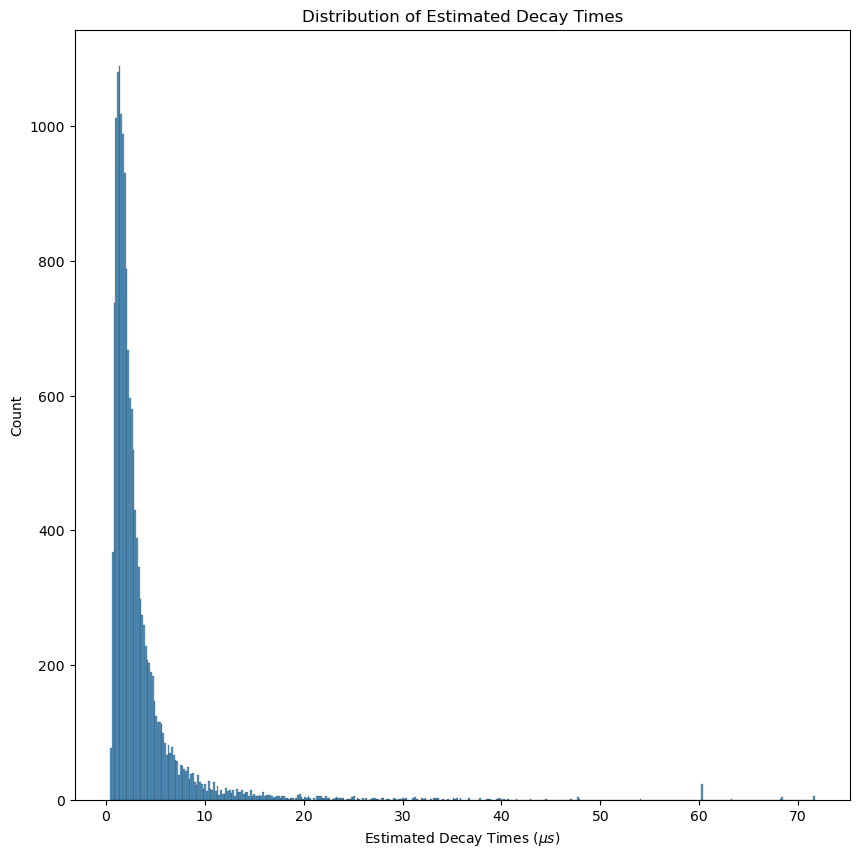

In [ ]:
# Plot histogram of estimated decay time
plt.figure(figsize=(10,10))
ax = sns.histplot(tau_estimated)
plt.title("Distribution of Estimated Decay Times")
plt.xlabel("Estimated Decay Times ($\\mu s$)")